In [1]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def color_string(order, s : str):
    if order in [6, 8]:
        return bcolors.FAIL + s + bcolors.ENDC
    else:
        return s

In [2]:
from typing import List, Dict, Set
from enum import Enum

class ResourceType(Enum):
    NotSet = 0
    Tree = 1
    Grain = 2
    Steel = 3
    Sheep = 4
    Ground = 5
    Sea = 6
    UnCharted = 7
    OutOfRange = 8

class Gift:
    odds = {
        -1 : 0,
        2 : 1,
        3 : 2,
        4 : 3,
        5 : 4,
        6 : 5,
        8 : 5,
        9 : 4,
        10 : 3,
        11 : 2,
        12 : 1
    }

    
    
    def __init__(self, coord: tuple, number: int=-1, type: ResourceType=ResourceType.OutOfRange):
        assert(number in Gift.odds.keys())
        
        self.number = number
        self.type = type
        self.coord = coord
        self.neighbors : List[Gift] = []
        self.harbors : List[ResourceType] = []

    def style(self) -> dict:
        res = {
            "facecolor" : "w", 
            "textcolor" : "k", 
            "text" : "?"
            }
            
        if self.type == ResourceType.Sea:
            res['facecolor'] = 'blue'
            res['text'] = ""
        elif self.type == ResourceType.OutOfRange:
            res['facecolor'] = 'k'
            res['textcolor'] = "w"
            res['text'] = '{}'.format(self.coord)
        elif self.type == ResourceType.Tree:
            res['facecolor'] = 'green'
            res['textcolor'] = "k"
            res['text'] = '{}'.format(self.number)
        elif self.type == ResourceType.Grain:
            res['facecolor'] = 'gold'
            res['textcolor'] = "k"
            res['text'] = '{}'.format(self.number)
        elif self.type == ResourceType.Steel:
            res['facecolor'] = 'steelblue'
            res['textcolor'] = "w"
            res['text'] = '{}'.format(self.number)
        elif self.type == ResourceType.Sheep:
            res['facecolor'] = 'lime'
            res['textcolor'] = "k"
            res['text'] = '{}'.format(self.number)
        elif self.type == ResourceType.Ground:
            res['facecolor'] = 'brown'
            res['textcolor'] = "w"
            res['text'] = '{}'.format(self.number)
        
        return res

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np
import math
import abc

class Board(abc.ABC):
    radius = np.sqrt(1/3)
    def __init__(self, size: tuple):
        assert(len(size) == 2)
        assert(all(s > 0 for s in size))
        self.size = size
        
        self.gifts = self.__initialize_hex_map__()
        
    def __transform(self, row: int, col: int):
        assert(row >= 0 and col >= 0)
        
        x = (2 * col + row) * Board.radius * math.cos(math.radians(30))
        y = row * 3 / 2 * Board.radius
        
        return x, y
        
        
    def __initialize_hex_map__(self) -> Dict[tuple, Gift]:
        gifts = {}
        rows, cols = self.size
        for row in range(rows):
            for col in range(cols):
                gifts[(row, col)] = Gift(coord=(row, col))
        return gifts
    
    def draw(self):
        fig, ax = plt.subplots(1)
        ax.set_aspect('equal')
        for gift in self.gifts.values():
            coord, style  = self.__transform(*gift.coord), gift.style()
            hex = RegularPolygon(coord, numVertices=6, radius=Board.radius, alpha=1, edgecolor='k', facecolor=style['facecolor'])
            ax.add_patch(hex)
            plt.text(*coord, style['text'], fontsize = 15, ha='center', va='center', color=style['textcolor'])
        plt.autoscale(enable = True)
        plt.show()

    @abc.abstractmethod
    def generate(self, num_types: List[ResourceType], num_odds: List[int]):
        pass
    
class FogIsland(Board):
    def __init__(self):
        size = (8, 8)
        super().__init__(size)
        
        self.not_set = [
                    (0, 4), (0, 5), (0, 6),
                    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                    (2, 5), (2, 6),
                    (6, 0), (6, 1), (6, 2), (6, 3),
                    (7, 0), (7, 1), (7, 2),
        ]
    
        self.uncharted = [
                        (3, 0), (3, 1), (3, 2), (3, 3),
                        (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6),
                        (5, 5)
        ]
        
        self.seas = [
            (0, 3),
            (2, 1), (2, 2), (2, 3), (2, 4),
            (3, 4), (3, 5), (3, 6),
            (5, 0), (5, 1), (5, 2), (5, 3), (5, 4),
            (6, 4),
            (7, 3)
        ]
        
        for row, col in self.not_set:
            self.gifts[(row, col)].type = ResourceType.NotSet
        
        for row, col in self.uncharted:
            self.gifts[(row, col)].type = ResourceType.UnCharted
            
        for row, col in self.seas:
            self.gifts[(row, col)].type = ResourceType.Sea
            
    def generate(self, resources: Dict[ResourceType, int], dice_numbers: Dict[int, int]) -> bool:
        """Generate ForIsland map with rules

        Args:
            gift_type_dist (List[ResourceType]): the number of each resource type as the form of (Tree, Grain, Steal, Sheep, Ground)
            dice_number_dist (List[int]): the number of each odd  as the form of (2, 3, 4, 5, 6, 8, 9, 10, 11, 12)
        """
        # Conditions to complete the map
        if len(self.not_set) == 0:
            return True
        
        candidate = self.not_set.pop()
        default_type, default_number = self.gifts[candidate].type, self.gifts[candidate].number
        for type, rcnt in resources.items():
            if rcnt == 0:
                continue

            self.gifts[candidate].type = type
            resources[type] -= 1

            for dice, dcnt in dice_numbers.items():
                if dcnt == 0:
                    continue

                self.gifts[candidate].number = dice
                dice_numbers[dice] -= 1
                if self.generate(resources, dice_numbers):
                    return True
                dice_numbers[dice] += 1
                self.gifts[candidate].number = default_number
            resources[type] += 1
            self.gifts[candidate].type = default_type
        self.not_set.append(candidate)
        
        return False
        

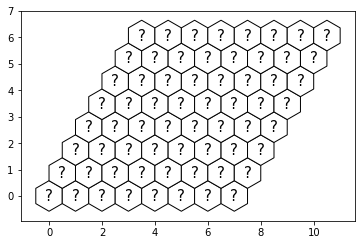

In [4]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
catan = FogIsland()
catan.draw()

In [64]:
resources = {
    ResourceType.Tree : 4,
    ResourceType.Grain : 3,
    ResourceType.Steal : 3,
    ResourceType.Sheep : 4,
    ResourceType.Ground : 3
}

number_dist = {
    2 : 1,
    3 : 2,
    4 : 2,
    5 : 2,
    6 : 2, 
    8 : 2,
    9 : 2,
    10 : 2,
    11 : 1,
    12 : 1
}
print(catan.generate(resources, number_dist))

True


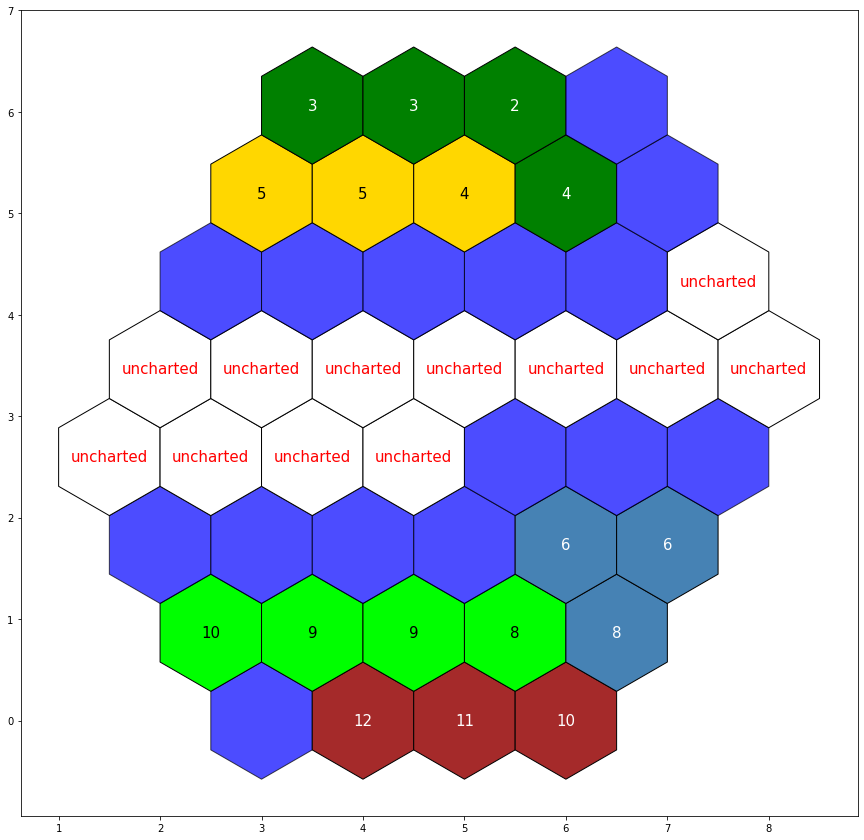

In [65]:
catan.draw()